Source: https://github.com/explosion/thinc/blob/master/examples/05_visualizing_models.ipynb

# Visualizing Thinc Models (with shape inference)
**Goal**: to visualize Thinc models and their inputs and outputs.

## 1. Define the Model
Start by defining the model with a number of layers chained together using the `chain` combinator.

In [1]:
from typing import Dict, Any

from pydot import Dot, Node
from thinc.api import chain, expand_window, Relu, Maxout, Linear, Softmax, Model

numHidden: int = 32
dropout: float = 0.2

model: Model = chain(
    expand_window(window_size = 3),
    Relu(nO = numHidden, dropout = dropout, normalize = True),
    Maxout(nO = numHidden * 4),
    Linear(nO = numHidden * 2),
    Relu(nO = numHidden, dropout = dropout, normalize = True),
    Linear(nO = numHidden),
    Relu(nO = numHidden, dropout = dropout),
    Softmax(),
)

In [2]:
model

## 2. Visualizing the model
Must add a node for each layer, edges connecting the nodes to the previous enode (except for first/last), and labels like "`name | (nO, nI)`", for instance "`maxout | (128, 32)`".

Function below takes a Thinc layer (such as a `Model` instance) and returns a label with the layer name and its dimensions, if available:

In [3]:
import thinc

# todo: type?
def getLabel(layer) -> str:
    # todo type
    layerName = layer.name
    nO: int = layer.get_dim("nO") if layer.has_dim("nO") else "?"
    nI: int = layer.get_dim("nI") if layer.has_dim("nI") else "?"

    return f"{layer.name}|({nO}, {nI})".replace(">", "&gt;")

Can now use `pydot` to create a visualization for a given model. Can customize the direction of the notes by setting "`rankdir`" (e.g. specifying "`TB`" for "top to bottom") and adjust the font and arrow styling. Call IPython's utilities so visualization renders nicely in the notebook.

In [4]:
import pydot

#from pydot import Dot
from IPython.display import SVG, display


def visualizeModel(model: Model):

    dot: Dot = pydot.Dot()

    # Styling, using the graphics engine
    dot.set(name = "rankdir", value = "LR")
    dot.set_node_defaults(shape = "record", fontname = "calibri", fontsize = "10")
    dot.set_edge_defaults(arrowsize = "0.7")

    # Adding nodes
    nodes: Dict[Any, Node] = {}

    for i, layer in enumerate(model.layers):
        label: str = getLabel(layer)

        # Create node using graphics engine
        node: Node = pydot.Node(name = layer.id, label = label)

        # Telling graphics machine to add a node.
        dot.add_node(graph_node = node)
        # Storing the current node so that we can see if there exists an edge from one node to another.
        nodes[layer.id] = node

        if i == 0:
            continue

        fromNode: Node = nodes[model.layers[i - 1].id]
        toNode: Node = nodes[layer.id]

        # If there is no edge from one node to the other node, add the edge (using graphics engine
        if not dot.get_edge(fromNode, toNode):
            dot.add_edge(graph_edge= pydot.Edge(fromNode, toNode))

    display(SVG(dot.create_svg()))
# strange: dot.create_svg() Ctrl-B says "cannot find declaration to go to" in IntelliJ but the code still runs!? - why is this method not visible?

Dimensions will show up as `(?, ?)` instead of the actual dimensions because Thinc allows the **defining of models with missing shapes** and can **infer the missing shapes from the data**.

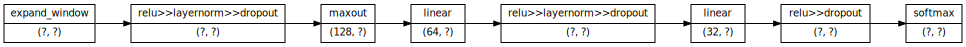

In [5]:
visualizeModel(model = model)

Call `model.initialize` to infer the missing shapes (using examples of expected input $X$ and expected output $Y$).

In [6]:
import numpy

X = numpy.zeros(shape=(5, 784), dtype="f")
Y = numpy.zeros(shape=(54000, 10), dtype="f")

model.initialize(X = X, Y = Y)

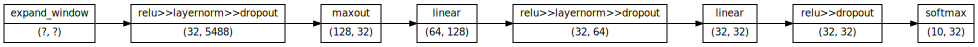

In [7]:
visualizeModel(model = model)